In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as wg
import IPython.display
import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import get_window
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.tsatools import freq_to_period
import math
import warnings
import copy
warnings.filterwarnings("ignore")
class STF_reflected:

    # init method or constructor 
    def __init__(self, data, window, period = None, pad = None, seasonal = 7):
        self.data = data
        self.window = window
        if period is None:
            freq = None
            if isinstance(data, (pd.Series, pd.DataFrame)):
                freq = getattr(data.index, 'inferred_freq', None)
            if freq is None:
                raise ValueError("Unable to determine period from data")
            period = freq_to_period(freq)
        self.period = period
        self._observed = data
        self.pad = pad
        if seasonal != 7:
            if seasonal % 2 == 0 or seasonal < 3:
                raise ValueError("seasonal must be an odd positive integer >= 3")
        self.seasonal = seasonal

    def fit(self):
        
        dt = 1 / (self.period)
        t = np.array(self.data.index)

        f = np.array(self.data.squeeze())
        half = np.floor(len(t)/2)
        # Reflect f onto f on both tails
        #TODO: Try reflecting only half the window width on both ends
        reflected = np.append(np.flip(f), f)
        reflected = np.append(reflected, np.flip(f))
        
        #TODO: Figure out why this is right here
        self.observed = pd.Series(self.data.squeeze(), self.data.index)


        n = len(reflected)
        #Compute FFT
        #TODO: Return fhat to see exactly what is being returned for fft (are they frequencies?)
        #TODO: Test rfft instead of fft
        fhat = np.fft.fft(reflected, n)
        fhat_seasonal = copy.copy(fhat)
        

        if self.window == "tukey":
            window = signal.tukey(len(reflected), alpha = self.pad)
        else:
            window = get_window(self.window, len(reflected))
        
        # X axis of freqs
        freq = (1 / (dt*n)) * np.arange(n)

        # Apply window to freqs
        freq = freq*window

        # Filter freqs for trend (low pass filter from Celevaland 1990) 
        filter_cutoff = 1.5*(1/self.seasonal)*(1/self.period)
     
        fhat[freq >= filter_cutoff] = 0

        # Filter freqs for seasonal (high pass filter)
        fhat_seasonal[freq < filter_cutoff] = 0

        # Inverse FFT for filtered time signal
        ffilt = np.fft.ifft(fhat)
        ffilt_seasonal = np.fft.ifft(fhat_seasonal)

        # Remove reflected padding
        ffilt = ffilt[len(f): (len(f)*2)]
        ffilt_seasonal = ffilt_seasonal[len(f): len(f)*2]
     
        trend = pd.Series(ffilt.real, self.data.index, name='trend')
    
        # This will be res.seasonal (ffilt_seasonal)
        season = pd.Series(ffilt_seasonal.real, self.data.index, name = 'season')
    
        # Find the residuals 
        residual = self.observed - ffilt_seasonal.real - ffilt.real
        resid = pd.Series(residual, self.data.index, name = "resid")

        # TODO: See if this is necessary for returning DecomposeResult()
        rw = pd.Series(np.ones(len(season)), self.data.index, name="robust_weight")
      
        # Initial Statistical Summary
       # print("The rmse", math.sqrt(mean_squared_error(co2["CO2"], (ffilt_seasonal + ffilt).real)))
        #print("The dot product of STF seasonal and trend components is ", np.round(ffilt_seasonal.dot(ffilt)))
        from statsmodels.tsa.seasonal import DecomposeResult
        return DecomposeResult(self._observed, season, trend, resid, rw)

In [11]:
#TODO: Write a loop
# do the decomposition for one iteration
# calculate correlation for each component
# find i that minimizes that correlation

In [12]:
import time

In [13]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.datasets import elec_equip as ds
import statsmodels.datasets

--- 0.11407852172851562 seconds ---
--- 0.14893245697021484 seconds ---


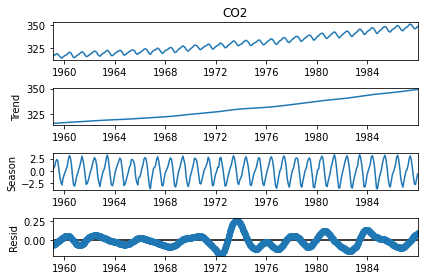

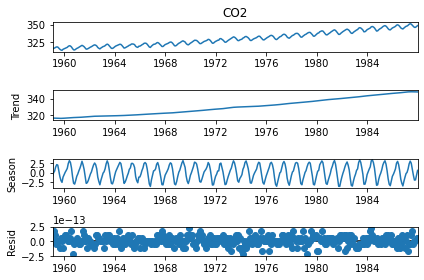

In [19]:
co2 =pd.read_csv('../data/co2.csv', index_col='date', parse_dates=True, squeeze=True)

start_time = time.time()
stl = STL(co2, seasonal=3)
res = stl.fit()
fig = res.plot()
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
stf = STF_reflected(co2, "blackman", seasonal=11)
res = stf.fit()
fig = res.plot()
print("--- %s seconds ---" % (time.time() - start_time))

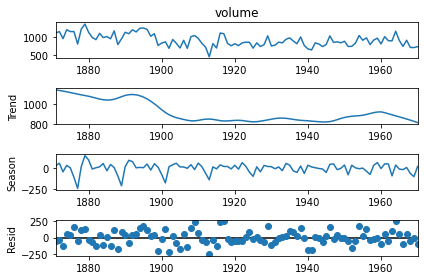

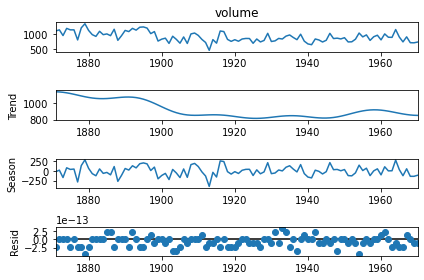

In [15]:
# Test stf vs stl on nile data
data = statsmodels.datasets.nile.load().data

data.index = data["year"]
stl = STL(data["volume"], period = 12, seasonal = 13)
res = stl.fit()
fig = res.plot()

stf = STF_reflected(data["volume"], window="blackman", period = 12, seasonal=13)
res = stf.fit()
fig = res.plot()

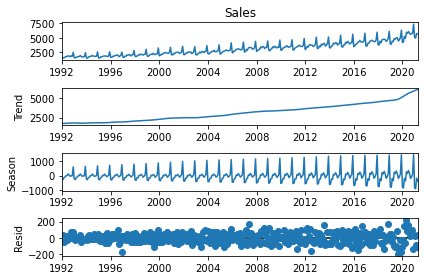

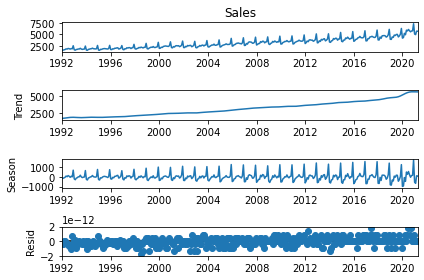

In [16]:
retail =pd.read_csv('../data/RetailSales.csv', index_col="DATE", parse_dates=True, squeeze=True)

stl = STL(retail, seasonal = 13)
res = stl.fit()
fig = res.plot()

stf = STF_reflected(retail, "blackman", pad = .5, seasonal = 13)
res = stf.fit()
fig = res.plot()

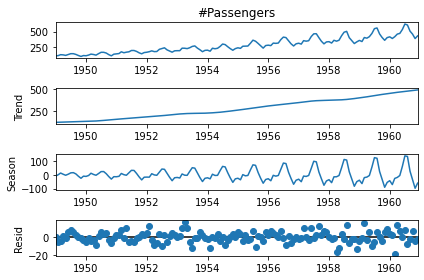

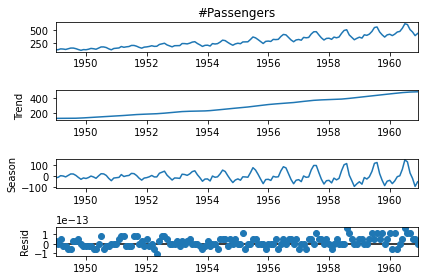

In [17]:
air = pd.read_csv('../data/AirPassengers.csv', index_col = "Month", parse_dates=True, squeeze=True)

stl = STL(air, seasonal = 13)
res = stl.fit()
fig = res.plot()

stf = STF_reflected(air, "blackman", pad = .5, seasonal=13)
res = stf.fit()
fig = res.plot()

--- 0.0898597240447998 seconds ---
--- 0.09046316146850586 seconds ---


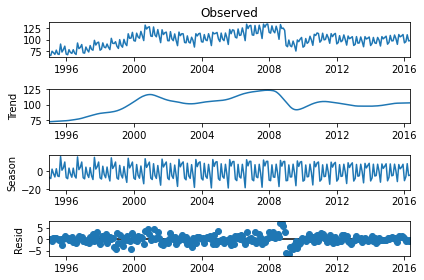

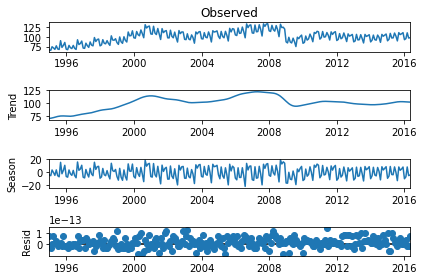

In [23]:
# Test stf vs stl on elec_equip data
elec_equip = ds.load().data
start_time = time.time()
stl = STL(elec_equip, seasonal = 13)
res_robust = stl.fit()
fig = res_robust.plot()
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
stf = STF_reflected(elec_equip, "blackman", pad = 1, seasonal=7)
res = stf.fit()
fig = res.plot()
print("--- %s seconds ---" % (time.time() - start_time))